In [1]:
type Arc
    initNode::Int 
    termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    flow::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64, freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0.)

Arc (constructor with 3 methods)

## Solve an inverse tarffic problem over polynomials of degree at most d

## Optionally use a regularizer from the poly kernel

In [65]:
using JuMP
using Gurobi
using Graphs
using Roots


polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  

polyEval(coeffs::Array{Float64, 1}, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)]) 

bpacost(flow::Float64, capacity::Float64, freeflowtime::Float64) = freeflowtime*(1 + .15 * (flow/capacity)^4)
bpacost(flow::Float64, arc) = bpacost(flow, arc.capacity, arc.freeflowtime)
bpacost(arc::Arc) = bpacost(arc.flow, arc)

bpacost (generic function with 3 methods)

In [3]:
function setUpFitting(deg::Int, c::Float64)

	m = Model(solver=GurobiSolver(OutputFlag=false))
    
	@defVar(m, coeffs[1:deg+1])
	@defVar(m, Calphas[1:deg+1])

	#build the graham matrix; cf. Ref. [21] (Regularization Networks and Support Vector Machines), page 47
	samples = linspace(0, 1, deg + 1)
	k(x,y) = (c + x*y)^deg
	K = [ k(x,y) for x = samples, y=samples]
	K = convert(Array{Float64, 2}, K)
	#assert(rank(K) == deg+1)
    
	C = chol(K + 1e-6* eye(deg+1))
	for i=1:deg + 1
		@addConstraint(m, polyEval(coeffs, samples[i]) == sum{C[j, i] * Calphas[j], j=1:deg+1})
	end
    
	@defVar(m, reg_term >= 0)
	reg_term_ = QuadExpr(Calphas[:], Calphas[:], ones(deg+1), AffExpr())
    
	@addConstraint(m, reg_term >= reg_term_)
    
	return m, coeffs, reg_term

end

setUpFitting (generic function with 1 method)

In [4]:
function fixCoeffs(m, fcoeffs, coeffs)
	for (fc, c) in zip(fcoeffs, coeffs[:])
		@addConstraint(m, fc == c)
	end
end

fixCoeffs (generic function with 1 method)

In [5]:
function addResid(m, coeffs, ys, demands, arcs, scaling)
    @defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

	@addConstraint(m, dual_cost == sum{demands[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.flow * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})

	@addConstraint(m, resid >= (dual_cost - primal_cost) / scaling )
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
	return resid
end

addResid (generic function with 1 method)

In [6]:
function addIncreasingCnsts(m, coeffs, arcs; TOL=0.)
	sorted_flows = sort([a.flow / a.capacity for a in values(arcs)])
	@addConstraint(m, polyEval(coeffs, 0) <= polyEval(coeffs, sorted_flows[1]))
	for i = 2:length(sorted_flows)
		@addConstraint(m, polyEval(coeffs, sorted_flows[i-1]) <= polyEval(coeffs, sorted_flows[i]) + TOL)
	end
    @addConstraint(m, coeffs[1] == 1)
end

addIncreasingCnsts (generic function with 1 method)

In [7]:
#equates the total cost of the network to the true total cost
function normalize(m, coeffs, tot_true_cost::Float64, arcs)
	@addConstraint(m, 
		sum{a.freeflowtime * a.flow * polyEval(coeffs, a.flow / a.capacity), a=values(arcs)} == tot_true_cost)
end

function normalize(m, coeffs, scaled_flow::Float64, cost::Float64)
	@addConstraint(m, polyEval(coeffs, scaled_flow) == cost)
end

function normalize(m, coeffs, scaled_flows::Array{Float64, 1}, avgCost::Float64)
    @addConstraint(m, sum{polyEval(coeffs, f), f=scaled_flows} == avgCost * length(scaled_flows))
end

normalize (generic function with 3 methods)

In [8]:
function addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
	@defVar(m, ys[keys(demands), 1:numNodes])
	for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end
	return ys
end

addNetworkCnsts (generic function with 1 method)

In [9]:
############
#Read in the demand file
file = open("../data_original/SiouxFalls_trips.txt")
demands = Dict{(Int64,Int64), Float64}()
s = 0
for line in eachline(file)
    if contains(line, "Origin")
        s = int(split(line)[2])
    else
        pairs = split(line, ";")
        for pair in pairs
            if !contains(pair, "\n")
                pair_vals = split(pair, ":")
                t, demand = int(pair_vals[1]), float(pair_vals[2])
                demands[(s,t)] = demand 
            end
        end
    end
end                
close(file)

In [10]:
############
#read in the arc files
arcs = Dict{(Int, Int), Arc}()
file = open("../data_original/SiouxFalls_net.txt")
inHeader=true
for line in eachline(file)
    if inHeader
        inHeader = !contains(line, "Init node")
        continue
    end
    vals = split(line, )
    arcs[(int(vals[1]), int(vals[2]))] = Arc(int(vals[1]), int(vals[2]), float(vals[3]), float(vals[5]))
end
close(file)

In [11]:
###########
#read in the initial flows
file = open("../data_original/SiouxFallsFlow.txt")
ix = 0; 
for line in eachline(file)
    ix +=1
    if ix ==1
        continue
    end
    vals = split(line)
    arcs[(int(vals[1]), int(vals[2]))].flow = float(vals[3])
end
close(file)

In [12]:
##########
# Set up demand data and flow data
##########

flow_data = Array(Float64, length(arcs))
flows = Dict{(Int64,Int64), Float64}()
demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs)
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end

for odpair in keys(demands)
    if ! haskey(demand_data, odpair)
        demand_data[odpair] = [demands[odpair], ]
    else
        push!(demand_data[odpair], demands[odpair])
    end
end

flow_data = [a.flow::Float64 for a in vArcs]

for a in vArcs
    flows[(a.initNode, a.termNode)] = a.flow
end

In [13]:
flows

Dict{(Int64,Int64),Float64} with 76 entries:
  (15,19) => 19083.289764747366
  (20,21) => 6302.022874186994
  (22,20) => 7000.0
  (23,22) => 9626.21020048335
  (10,11) => 17726.62503296105
  (8,9)   => 6882.664912661778
  (13,12) => 12378.642039980477
  (24,21) => 10259.524716223794
  (3,1)   => 8094.6576464564205
  (19,17) => 9941.856797956832
  (4,5)   => 18006.371019862527
  (17,16) => 11683.838282439508
  (20,22) => 7000.0
  (22,21) => 8607.387929735014
  (18,16) => 15333.406655753832
  (6,5)   => 8806.498666814754
  (16,17) => 11695.002916533696
  (22,15) => 18386.47276399956
  (1,2)   => 4494.6576464564205
  (22,23) => 9661.824231365848
  (19,20) => 8688.367040494595
  (9,8)   => 6836.705975294404
  (11,12) => 8365.285653859217
  (3,4)   => 14006.371019862527
  (8,16)  => 8388.71306300359
  ⋮       => ⋮

In [14]:
using JSON

#load node-link incidence
nodeLink = readall("node_link_incidence_Sioux.json");
nodeLink = JSON.parse(nodeLink);

In [15]:
link_label_dict = readall("link_label_dict_Sioux.json");
link_label_dict = JSON.parse(link_label_dict);

In [16]:
link_label_dict["1"]

int(split(link_label_dict["1"], ',')[1]), int(split(link_label_dict["1"], ',')[2])

flows[int(split(link_label_dict["1"], ',')[1]), int(split(link_label_dict["1"], ',')[2])]

string(1)

"1"

In [17]:
function addResid_(m, coeffs, ys, demands_, demands, arcs, scaling)
    @defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

    for (s,t)=keys(demands)
        @addConstraint(m, demands_[(s,t)] >= 0)
    end

	@addConstraint(m, dual_cost == sum{demands_[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.flow * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})

	@addConstraint(m, resid >= (dual_cost - primal_cost) / scaling )
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
	return resid
end

addResid_ (generic function with 1 method)

In [18]:
##########
#Fitting Funcs
##########

function train_cy(lam::Float64, deg::Int, c::Float64, demands, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows

    avgCost = mean( [bpacost(a.flow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.flow / a.capacity for a in values(arcs)], avgCost)


    resids = Variable[]
    

    #copy the flow data over to the arcs
    for (ix, a) in enumerate(vArcs)
        a.flow = flow_data[ix]
    end

    #Dual Feasibility
    ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)

    #add the residual for this data point
    push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))


    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    return [getValue(coeffs[i]) for i =1:length(coeffs)], getValue(ys), getValue(resids)
end

train_cy (generic function with 1 method)

In [19]:
nodeLink["0-75"]

0.0

In [20]:
demands

Dict{(Int64,Int64),Float64} with 576 entries:
  (23,8)  => 300.0
  (8,23)  => 300.0
  (6,9)   => 400.0
  (18,3)  => 0.0
  (21,13) => 600.0
  (22,16) => 1200.0
  (15,17) => 1500.0
  (22,14) => 1200.0
  (13,9)  => 600.0
  (23,10) => 1800.0
  (24,22) => 1100.0
  (8,9)   => 800.0
  (9,1)   => 500.0
  (17,14) => 700.0
  (16,6)  => 900.0
  (16,12) => 700.0
  (16,13) => 600.0
  (22,2)  => 100.0
  (24,3)  => 0.0
  (7,16)  => 1400.0
  (1,12)  => 200.0
  (4,5)   => 500.0
  (11,8)  => 800.0
  (18,21) => 100.0
  (19,4)  => 200.0
  ⋮       => ⋮

In [21]:
outfile = open("demands_Sioux.json", "w")

JSON.print(outfile, demands)

close(outfile)

In [22]:
##########
#Fitting Funcs
##########

function train_cd(lam::Float64, deg::Int, c::Float64, ys, flow_data, flows, nodeLink, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows

    avgCost = mean( [bpacost(a.flow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.flow / a.capacity for a in values(arcs)], avgCost)

    resids = Variable[]
    

    #copy the flow data over to the arcs
    for (ix, a) in enumerate(vArcs)
        a.flow = flow_data[ix]
    end

    for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end

    @defVar(m, demands_[keys(demands)])
    
    for (s,t) = keys(demands)
        @addConstraint(m, demands_[(s,t)] >= 0)
        @addConstraint(m, demands_[(s,t)] - demands[(s,t)] <= demands[(s,t)] * 0.05)
        @addConstraint(m, demands[(s,t)] - demands_[(s,t)] <= demands[(s,t)] * 0.05)
    end
    
    numLinks = length(flows)  # number of links
    @defVar(m, odLinkFlow[keys(demands), 1:numLinks])
    for (s,t) = keys(demands)
        for k = 1:numLinks
            @addConstraint(m, odLinkFlow[(s,t), k] >= 0)
        end
    end
    
    for k = 1:numLinks
        linkFlowPartial = 0
        for (s,t) = keys(demands)
            linkFlowPartial += odLinkFlow[(s,t), k]
        end
        key = (int(split(link_label_dict["$(k-1)"], ',')[1]), int(split(link_label_dict["$(k-1)"], ',')[2]))
        @addConstraint(m, linkFlowPartial == flows[key])
    end

    for l = 1:numNodes
        for (s,t) = keys(demands)
            if s == t
                @addConstraint(m, demands_[(s,t)] == 0)
            else
                odLinkFlowPartial = 0
                for k = 1:numLinks
                    odLinkFlowPartial += nodeLink["$(l-1)-$(k-1)"] * odLinkFlow[(s,t), k]
                end

                if (l == s)
                    @addConstraint(m, odLinkFlowPartial + demands_[(s,t)] == 0)
                elseif (l == t)
                    @addConstraint(m, odLinkFlowPartial - demands_[(s,t)] == 0)
                else
                    @addConstraint(m, odLinkFlowPartial == 0)
                end
            end
        end
    end
    
    #add the residual for this data point
    push!(resids, addResid_(m, coeffs, ys, demands_, demands, arcs, 1e6))

    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    return [getValue(coeffs[i]) for i =1:length(coeffs)], getValue(demands_), getValue(resids)
end

train_cd (generic function with 1 method)

In [23]:
demands[(1, 1)]

0.0

In [24]:
#include("trafficCval.jl")

coeffs_dict = Dict{(Int64,Float64,Float64),Array{Float64,1}}()

deg = 6
c = 3.41
lam = 1.

demands_0 = copy(demands)

Dict{(Int64,Int64),Float64} with 576 entries:
  (23,8)  => 300.0
  (8,23)  => 300.0
  (6,9)   => 400.0
  (18,3)  => 0.0
  (21,13) => 600.0
  (22,16) => 1200.0
  (15,17) => 1500.0
  (22,14) => 1200.0
  (13,9)  => 600.0
  (23,10) => 1800.0
  (24,22) => 1100.0
  (8,9)   => 800.0
  (9,1)   => 500.0
  (17,14) => 700.0
  (16,6)  => 900.0
  (16,12) => 700.0
  (16,13) => 600.0
  (22,2)  => 100.0
  (24,3)  => 0.0
  (7,16)  => 1400.0
  (1,12)  => 200.0
  (4,5)   => 500.0
  (11,8)  => 800.0
  (18,21) => 100.0
  (19,4)  => 200.0
  ⋮       => ⋮

In [25]:
fcoeffs, ys, resids = train_cy(lam, deg, c, demands_0, flow_data, arcs)
coeffs_dict[(deg, c, lam)] = fcoeffs

7-element Array{Float64,1}:
  1.0       
  0.00811581
 -0.0308172 
  0.04389   
  0.120305  
  0.00962954
 -0.00120584

In [26]:
fcoeffs, demands_, resides_ = train_cd(lam, deg, c, ys, flow_data, flows, nodeLink, arcs)
for (s,t) = keys(demands)
    demands_0[(s,t)] = demands_[(s,t)]
end
coeffs_dict[(deg, c, lam)] = fcoeffs

7-element Array{Float64,1}:
  1.0       
  0.00811157
 -0.0307916 
  0.0438539 
  0.120333  
  0.00960501
 -0.00119956

/home/jzh/.julia/v0.3/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
INFO: Loading help data...


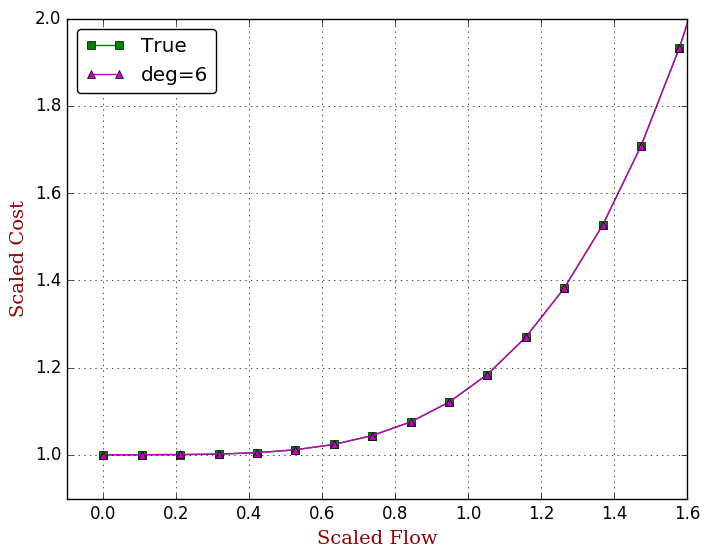

In [27]:
using PyPlot

true_coeffs = [1, 0, 0, 0, .15]

fcoeffs = coeffs_dict[(6, 3.41, 1.)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(fcoeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("fitting_Sioux.pdf")

In [28]:
demands_0

Dict{(Int64,Int64),Float64} with 576 entries:
  (23,8)  => 299.8472991513264
  (8,23)  => 301.7868992933728
  (6,9)   => 391.6550245803358
  (18,3)  => -0.0
  (21,13) => 572.5308226857171
  (22,16) => 1149.891205181834
  (15,17) => 1572.8146554432171
  (22,14) => 1172.3563740151762
  (13,9)  => 628.9299385657738
  (23,10) => 1752.203877047718
  (24,22) => 1112.9908608865637
  (8,9)   => 837.4479490435394
  (9,1)   => 523.3632088884866
  (17,14) => 733.6644599296308
  (16,6)  => 896.201981948164
  (16,12) => 673.3169705019402
  (16,13) => 584.9230551052686
  (22,2)  => 98.05257274862156
  (24,3)  => -0.0
  (7,16)  => 1343.2278149950457
  (1,12)  => 209.92517654910375
  (4,5)   => 501.6704694018562
  (11,8)  => 822.0078367032239
  (18,21) => 97.32606711117162
  (19,4)  => 209.56791932347156
  ⋮        => ⋮

In [29]:
demands

Dict{(Int64,Int64),Float64} with 576 entries:
  (23,8)  => 300.0
  (8,23)  => 300.0
  (6,9)   => 400.0
  (18,3)  => 0.0
  (21,13) => 600.0
  (22,16) => 1200.0
  (15,17) => 1500.0
  (22,14) => 1200.0
  (13,9)  => 600.0
  (23,10) => 1800.0
  (24,22) => 1100.0
  (8,9)   => 800.0
  (9,1)   => 500.0
  (17,14) => 700.0
  (16,6)  => 900.0
  (16,12) => 700.0
  (16,13) => 600.0
  (22,2)  => 100.0
  (24,3)  => 0.0
  (7,16)  => 1400.0
  (1,12)  => 200.0
  (4,5)   => 500.0
  (11,8)  => 800.0
  (18,21) => 100.0
  (19,4)  => 200.0
  ⋮        => ⋮

In [30]:
# based on https://github.com/chkwon/TrafficAssignment.jl

include("load_network_uni-class.jl")

using Graphs

function create_graph(start_node, end_node)
    @assert Base.length(start_node)==Base.length(end_node)

    no_node = max(maximum(start_node), maximum(end_node))
    no_arc = Base.length(start_node)

    graph = simple_inclist(no_node)
    for i=1:no_arc
        add_edge!(graph, start_node[i], end_node[i])
    end
    return graph
end

function get_vector(state, origin, destination, link_dic)
    current = destination
    parent = -1
    x = zeros(Int, maximum(link_dic))

    while parent != origin
        parent = state.parents[current]

        link_idx = link_dic[parent,current]

        if link_idx != 0
            x[link_idx] = 1
        end

        current = parent
    end

    return x
end

get_vector (generic function with 1 method)

In [71]:
ta_data = load_ta_network("Sioux Falls");

# ta_data.travel_demand;

# unpacking data from ta_data
network_name = ta_data.network_name

number_of_zones = ta_data.number_of_zones
number_of_nodes = ta_data.number_of_nodes
first_thru_node = ta_data.first_thru_node
number_of_links = ta_data.number_of_links

start_node = ta_data.start_node
end_node = ta_data.end_node
capacity = ta_data.capacity
link_length = ta_data.link_length

free_flow_time = ta_data.free_flow_time
B = ta_data.B
power = ta_data.power
speed_limit = ta_data.speed_limit
toll = ta_data.toll
link_type = ta_data.link_type
number_of_zones = ta_data.number_of_zones
total_od_flow = ta_data.total_od_flow
# travel_demand = ta_data.travel_demand
od_pairs = ta_data.od_pairs

toll_factor = ta_data.toll_factor
distance_factor = ta_data.distance_factor

best_objective = ta_data.best_objective

travel_demand = zeros(24, 24)

for (s,t)=keys(demands)
    travel_demand[s,t] = demands_0[(s,t)]
end

In [32]:
# preparing a graph
graph = create_graph(start_node, end_node)
link_dic = sparse(start_node, end_node, 1:number_of_links);

In [33]:
function BPR(x)
    bpr = similar(x)
    for i=1:length(bpr)
        bpr[i] = free_flow_time[i] * polyEval(fcoeffs, x[i]/capacity[i])
#         bpr[i] = free_flow_time[i] * ( 1.0 + B[i] * (x[i]/capacity[i])^power[i] )
    end
    return bpr
end

BPR (generic function with 1 method)

In [34]:
function all_or_nothing(travel_time)
    state = []
    path = []
    x = zeros(size(start_node))

    for r=1:size(travel_demand)[1]
        # for each origin node r, find shortest paths to all destination nodes
        state = dijkstra_shortest_paths(graph, travel_time, r)

        for s=1:size(travel_demand)[2]
            # for each destination node s, find the shortest-path vector
            # load travel demand
            x = x + travel_demand[r,s] * get_vector(state, r, s, link_dic)
        end
    end

    return x
end

all_or_nothing (generic function with 1 method)

In [35]:
# Finding a starting feasible solution
travel_time = BPR(zeros(number_of_links))
xl = all_or_nothing(travel_time);

max_iter_no = 2e3
l = 1
#average_excess_cost = 1
tol = 1e-6

while l < max_iter_no
    l += 1
    
    xl_old = xl
    
    # Finding yl
    travel_time = BPR(xl)
    
    yl = all_or_nothing(travel_time)
    
    assert(yl != xl)
    
    xl = xl + (yl - xl)/l
    
    xl_new = xl
    
    relative_gap = norm(xl_new - xl_old, 1) / norm(xl_new, 1)

#     if l % 500 == 0
#         print("l = $l------------------------------------------------\n")
#         print("relative_gap is $relative_gap\n")
#     end

    if relative_gap < tol 
        print("l = $l------------------------------------------------\n")
        print("relative_gap is $relative_gap\n")
        break
    end
    
end

tapFlows = Dict{(Int64,Int64),Float64}()

for i = 1:length(ta_data.start_node)
    key = (ta_data.start_node[i], ta_data.end_node[i])
    tapFlows[key] = xl[i]
end

tapFlows

Dict{(Int64,Int64),Float64} with 76 entries:
  (15,19) => 19122.431147705018
  (20,21) => 6245.794987322632
  (22,20) => 7008.256712095961
  (23,22) => 9666.399492216604
  (10,11) => 17611.50990656922
  (8,9)   => 6840.478097419327
  (13,12) => 12313.149313741273
  (24,21) => 10308.54087699824
  (3,1)   => 8127.6338730678435
  (19,17) => 9953.224009219357
  (4,5)   => 18054.7322767356
  (17,16) => 11693.247905994382
  (20,22) => 7007.992042932931
  (22,21) => 8624.465553209917
  (18,16) => 15305.263585978742
  (6,5)   => 8800.46364106035
  (16,17) => 11682.534110546734
  (22,15) => 18409.497302844946
  (1,2)   => 4526.495182426613
  (22,23) => 9627.647621487049
  (19,20) => 8711.211303881388
  (9,8)   => 6885.456253981151
  (11,12) => 8408.19222983249
  (3,4)   => 14055.402170789996
  (8,16)  => 8409.141709525218
  ⋮        => ⋮

In [36]:
flows

Dict{(Int64,Int64),Float64} with 76 entries:
  (15,19) => 19083.289764747366
  (20,21) => 6302.022874186994
  (22,20) => 7000.0
  (23,22) => 9626.21020048335
  (10,11) => 17726.62503296105
  (8,9)   => 6882.664912661778
  (13,12) => 12378.642039980477
  (24,21) => 10259.524716223794
  (3,1)   => 8094.6576464564205
  (19,17) => 9941.856797956832
  (4,5)   => 18006.371019862527
  (17,16) => 11683.838282439508
  (20,22) => 7000.0
  (22,21) => 8607.387929735014
  (18,16) => 15333.406655753832
  (6,5)   => 8806.498666814754
  (16,17) => 11695.002916533696
  (22,15) => 18386.47276399956
  (1,2)   => 4494.6576464564205
  (22,23) => 9661.824231365848
  (19,20) => 8688.367040494595
  (9,8)   => 6836.705975294404
  (11,12) => 8365.285653859217
  (3,4)   => 14006.371019862527
  (8,16)  => 8388.71306300359
  ⋮        => ⋮

In [37]:
fcoeffs

7-element Array{Float64,1}:
  1.0       
  0.00811157
 -0.0307916 
  0.0438539 
  0.120333  
  0.00960501
 -0.00119956

In [38]:
function sa(x, a)  # calculate the partial derivatives of c_a w.r.t. x_a
    assert(a <= length(x) && a >= 1)
    n = length(fcoeffs)
    dcdx = 0
    for i=2:n
        dcdx += (i-1) * fcoeffs[i] * (x[a]/capacity[a])^(i-2)
    end
    dcdx *= free_flow_time[a]/capacity[a]
    return dcdx
end

sa (generic function with 1 method)

In [39]:
tapFlows

Dict{(Int64,Int64),Float64} with 76 entries:
  (15,19) => 19122.431147705018
  (20,21) => 6245.794987322632
  (22,20) => 7008.256712095961
  (23,22) => 9666.399492216604
  (10,11) => 17611.50990656922
  (8,9)   => 6840.478097419327
  (13,12) => 12313.149313741273
  (24,21) => 10308.54087699824
  (3,1)   => 8127.6338730678435
  (19,17) => 9953.224009219357
  (4,5)   => 18054.7322767356
  (17,16) => 11693.247905994382
  (20,22) => 7007.992042932931
  (22,21) => 8624.465553209917
  (18,16) => 15305.263585978742
  (6,5)   => 8800.46364106035
  (16,17) => 11682.534110546734
  (22,15) => 18409.497302844946
  (1,2)   => 4526.495182426613
  (22,23) => 9627.647621487049
  (19,20) => 8711.211303881388
  (9,8)   => 6885.456253981151
  (11,12) => 8408.19222983249
  (3,4)   => 14055.402170789996
  (8,16)  => 8409.141709525218
  ⋮        => ⋮

In [40]:
x = zeros(size(start_node))
for k = 1:length(x)
    key = (int(split(link_label_dict["$(k-1)"], ',')[1]), int(split(link_label_dict["$(k-1)"], ',')[2]))
    x[k] = tapFlows[key]
end

In [41]:
x

76-element Array{Float64,1}:
  4526.5 
  8102.24
  4501.1 
  5994.55
  8127.63
 14055.4 
 10009.1 
 14031.8 
 18054.7 
  5310.31
 18030.3 
  8809.27
 15808.9 
     ⋮   
  8611.81
 10259.2 
 18409.5 
  7008.26
  8624.47
  9627.65
  8399.97
  9666.4 
  7868.05
 11121.8 
 10308.5 
  7910.06

## Obtain $\left( {\frac{{\partial {c_a}\left( {{g^l}} \right)}}{{\partial {v_a}}};a \in \mathcal{A}} \right)$ 

In [42]:
saVec = similar(x)
for a = 1:length(x)
    saVec[a] = sa(x, a)
end

In [43]:
saVec[1:5]

5-element Array{Float64,1}:
 9.22049e-7
 3.96278e-6
 9.15435e-7
 0.00106958
 4.00187e-6

## Now we want to solve:
$$\begin{gathered}
  {\text{[P2]  }}\mathop {\min }\limits_{\textbf{d}} {\text{  }}\sum\limits_{a \in \mathcal{A}} {\frac{{\partial {c_a}\left( {{g^l}} \right)}}{{\partial {v_a}}}d_a^2}  \hfill \\
  {\text{         s}}{\text{.t}}{\text{.      }}\Lambda \textbf{x} = {\textbf{e}_i},{\text{  }}i \in \mathcal{I}, \hfill \\
  {\text{                  }}\textbf{d} = \Delta \textbf{x}, \hfill \\ 
\end{gathered}$$
where $\Lambda $ is the OD pair-path incidence, and $\Delta$ is the link-path incidence.

The solution to [P2] is the $i$-th row of the Jacobian $\left[ {\frac{{\partial {v_a}\left( {{g^l}} \right)}}{{\partial {g_i}}}; \,\,a \in \mathcal{A},\,i \in \mathcal{I}} \right]$.


Reference:

A heuristic for the bilevel origin-destination matrix estimation problem
http://www.sciencedirect.com/science/article/pii/S019126150700080X

In [44]:
#load OD pair-route incidence
odPairRoute = readall("od_pair_route_incidence_Sioux.json");
odPairRoute = JSON.parse(odPairRoute);

#load link-route incidence
linkRoute = readall("link_route_incidence_Sioux.json");
linkRoute = JSON.parse(linkRoute);

#load OD pair labels
odPairLabel = readall("od_pair_label_dict_Sioux.json");
odPairLabel = JSON.parse(odPairLabel);

odPairLabel_ = readall("od_pair_label_dict__Sioux.json");
odPairLabel_ = JSON.parse(odPairLabel_);

In [45]:
# express the demand data as vector (array)

demandsVec = zeros(length(demands))

for i = 1:length(demandsVec)
    demandsVec[i] = demands_0[(odPairLabel_["$i"][1], odPairLabel_["$i"][2])]
end

In [46]:
demandsVec[1:5]

5-element Array{Float64,1}:
  -0.0   
 104.974 
  98.4159
 475.702 
 190.564 

In [47]:
# convert the demand data into dictionary

demandsDict = similar(demands)

for key = keys(demands)
    demandsDict[key] = demandsVec[odPairLabel["($(key[1]), $(key[2]))"]]
end

In [48]:
"1-200" in keys(odPairRoute)

false

In [68]:
numLinks = size(start_node)[1]
numRoutes = length(odPairRoute)

exception on 2: ERROR: start_node not defined
 in eval at /home/jzh/julia/base/sysimg.jl:7
 in anonymous at multi.jl:1310
 in anonymous at multi.jl:848
 in run_work_thunk at multi.jl:621
 in run_work_thunk at multi.jl:630
 in anonymous at task.jl:6
exception on 4: exception on 7: ERROR: start_node not defined
 in eval at /home/jzh/julia/base/sysimg.jl:7
 in anonymous at multi.jl:1310
 in anonymous at multi.jl:848
 in run_work_thunk at multi.jl:621
 in run_work_thunk at multi.jl:630
 in anonymous at task.jl:6
ERROR: start_node not defined
 in eval at /home/jzh/julia/base/sysimg.jl:7
 in anonymous at multi.jl:1310
 in anonymous at multi.jl:848
 in run_work_thunk at multi.jl:621
 in run_work_thunk at multi.jl:630
 in anonymous at task.jl:6
exception on 3: exception on 6: exception on 5: ERROR: start_node not defined
 in eval at /home/jzh/julia/base/sysimg.jl:7
 in anonymous at multi.jl:1310
 in anonymous at multi.jl:848
 in run_work_thunk at multi.jl:621
 in run_work_thunk at multi.jl:630

In [66]:
# solve [P2]
function solveJacob(i_th)
    
    jacobi = Model(solver=GurobiSolver(OutputFlag=false))

    @defVar(jacobi, d[1:numLinks])
    @defVar(jacobi, x[1:numRoutes])

    for i=1:length(demandsVec)
        sumLamX = 0
        for j=1:numRoutes
            if "$(i)-$(j)" in keys(odPairRoute)
                sumLamX += x[j]
            end
        end
        if i == i_th
            @addConstraint(jacobi, sumLamX == 1)
        else
            @addConstraint(jacobi, sumLamX == 0)
        end
    end

    for i=1:numLinks
        sumDeltaX = 0
        for j=1:numRoutes
            if "$(i)-$(j)" in keys(linkRoute)
                sumDeltaX += x[j]
            end
        end
        @addConstraint(jacobi, sumDeltaX == d[i])
    end

    @setObjective(jacobi, Min, sum{saVec[i] * (d[i])^2, i = 1:length(numLinks)})

    solve(jacobi)

    return getValue(d)
end

In [67]:
M = {1:8}
pmap(solveJacob, M)

exception on 2: ERROR: numLinks not defined
 in solveJacob at In[66]:125
 in anonymous at multi.jl:855
 in run_work_thunk at multi.jl:621
 in anonymous at task.jl:855


1-element Array{Any,1}:
 UndefVarError(:numLinks)

In [61]:
jacob = zeros(length(demandsVec), numLinks)

# addprocs(7)  # parallel computing

for i=1:length(demandsVec)
    d = solveJacob(i)
    for j=1:numLinks
        jacob[i,j] = d[j]
    end
    println("$(i)-th row completed")
end

1-th row completed
2-th row completed
3-th row completed
4-th row completed
5-th row completed
6-th row completed


LoadError: interrupt
while loading In[61], in expression starting on line 5

In [60]:
jacob

576x76 Array{Float64,2}:
 -0.0  1.0  0.0  0.0  0.0  1.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.0  1.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.0  1.0  0.0  0.0  1.0  0.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.0  1.0  1.0  0.0  1.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  ⋮          

In [62]:
M = {rand(1000,1000) for i=1:10}
pmap(svd, M)

10-element Array{Any,1}:
 (
1000x1000 Array{Float64,2}:
 -0.0319652   0.0104189     0.0157388   …   0.0653918    -0.0521525  
 -0.031391    0.0458657     0.00100725     -0.0130875    -0.00555528 
 -0.0319157  -0.0160645    -0.0189691      -0.0131195     0.00738698 
 -0.0319064   0.0182532    -0.0148786      -0.0243007     0.000883813
 -0.0323962  -0.0225797     0.00123175     -0.0146999     0.0492076  
 -0.030949   -0.0110564    -0.0143354   …  -0.0407302    -0.0470007  
 -0.0319053   0.0651823     0.0210659       0.00417674   -0.00193778 
 -0.0322023   0.0311495     0.0157302      -0.0108527     0.0141575  
 -0.0326894   0.0154871     0.00132133      0.00996687    0.0565427  
 -0.0324833  -0.0359806     0.0321342      -0.0632611     0.0481499  
 -0.0315936  -0.0212435     0.0096273   …  -0.0259583    -0.00100895 
 -0.0327001  -0.0274148     0.00916748      0.0143607    -0.0429603  
 -0.0315777  -0.00111832   -0.0313072       0.0287469    -0.0281652  
  ⋮                               